### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

np.random.seed(0)
random.seed(0)

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent():
    def __init__(self, environment, action_size, state_size, hyperparameter):
        # Define size of state and action
        self.environment = environment
        self.state_size = state_size
        self.action_size = action_size

        # hyper parameters for the DQN
        self.discount_factor = hyperparameter['discount_factor'] or 0.95
        self.learning_rate = hyperparameter['learning_rate'] or 0.01
        self.epsilon = hyperparameter['epsilon'] or 1
        self.epsilon_max = hyperparameter['epsilon_max'] or 1
        self.epsilon_decay = hyperparameter['epsilon_decay'] or 0.0009
        self.epsilon_min = hyperparameter['epsilon_min'] or 0.01
        
        self.batch_size = hyperparameter['batch_size'] or 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    
    def set_epsilon(self, episode):
        self.epsilon = self.epsilon_min + (
            self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay * episode)

    def get_epsilon(self):
        return self.epsilon


    # approximate Q function using Neural Network
    def build_model(self):

        model = Sequential()

        # hidden layers
        model.add(Dense(36, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(36, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))

        return model


    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """
        (possible_actions_index, actions) = self.environment.requests(state)

        # 0.011
        if random.uniform(self.epsilon_max, self.epsilon_min) < self.get_epsilon(): 
            index = random.randrange(len(possible_actions_index))
            return (possible_actions_index[index], actions[index])

        else:
            state = np.array(self.environment.state_encod_arch1(state)).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            
            filter_q_value = np.take(q_value[0], possible_actions_index)
            
            if q_value[0][0] > np.max(filter_q_value):
                return (0, actions[-1])
            else:
                return (possible_actions_index[np.argmax(filter_q_value)], actions[np.argmax(filter_q_value)])


    def append_sample(self, state, action, reward, next_state, done):
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, done))


    def train_model(self):
        """
        train the neural network on a minibatch. Input to the network is the states,
        output is the target q-value corresponding to each action.
        """

        if len(self.memory) > self.batch_size:
            
            # sample minibatch from memory
            minibatch = random.sample(self.memory, self.batch_size)

            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = minibatch[i]
                update_input[i] = self.environment.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = self.environment.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)

            # target for q-network
            target_qval = self.model.predict(update_output)
            
            # for testing
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

#             # update the target values
#             for i in range(self.batch_size):
#                 if done[i]:
#                     target[i][actions[i]] = rewards[i]
#                 else: # non-terminal state
#                     target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # model fit
            history = self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

            # print(history.history['loss'])
            return history.history

    def get_qvalue(self, state):
        state = np.array(self.environment.state_encod_arch1(state)).reshape(1, self.state_size)
        return self.model.predict(state)

    def save_model_weights(self, name):
        self.model.save_weights(name)


In [5]:
Episodes = 4000

max_car_drive_time = 30 * 24

Hyperparameters = {
    'discount_factor': 0.95,
    'learning_rate' : 0.001,
    'epsilon': 1,
    'epsilon_max' : 1,
    'epsilon_decay' : 0.003,
    'epsilon_min': 0.01,
    'batch_size' : 64
}

state_size = 36


env = CabDriver()
(action_space, _, _) = env.reset()

action_size = len(action_space)

agent = DQNAgent(environment= env, action_size= action_size, state_size= state_size, hyperparameter= Hyperparameters)

(rewards_per_episode, nn_loss_per_episode) = ([],[])

### DQN block

In [ ]:
start_time = time.time()

for episode in range(1, Episodes + 1):
    
    done = False
    total_reward = 0
    agent_total_time = 0
    
    (_, _, curr_state) = env.reset()
    
    while not done:        
        (action_index, action) = agent.get_action(curr_state)
        
        (next_state, reward, total_worked_hours) = env.step(curr_state, action, Time_matrix)
        
        agent.append_sample(curr_state, action_index, reward, next_state, done)
        
        history = agent.train_model()

        total_reward += reward
        curr_state = next_state
        
        agent_total_time += total_worked_hours
        if agent_total_time >= max_car_drive_time:
            done = True
            
    agent.set_epsilon(episode)

    rewards_per_episode.append(total_reward)
    nn_loss_per_episode.append(history['loss'])
    
    if episode % 1000 == 0:
        agent.save_model_weights(name="model_weights.h5")
    
    if episode % 50 == 0:
        print('Episdoe:{} DriveTime:{} NN_loss:{} Reward:{} Epsilon:{}'.format(
            episode, agent_total_time, history['loss'], total_reward, agent.get_epsilon()))


elapsed_time = time.time() - start_time
print(elapsed_time)

Episdoe:50 DriveTime:722.0 NN_loss:[1598.135009765625] Reward:-361.0 Epsilon:0.8621008966608072
Episdoe:100 DriveTime:720.0 NN_loss:[2169.2509765625] Reward:279.0 Epsilon:0.7434100384749007
Episdoe:150 DriveTime:720.0 NN_loss:[1369.658447265625] Reward:558.0 Epsilon:0.6412518701055556
Episdoe:200 DriveTime:725.0 NN_loss:[1578.6802978515625] Reward:713.0 Epsilon:0.5533235197330862
Episdoe:250 DriveTime:721.0 NN_loss:[1207.4180908203125] Reward:670.0 Epsilon:0.47764288721360454
Episdoe:300 DriveTime:723.0 NN_loss:[1281.0433349609375] Reward:597.0 Epsilon:0.4125039631431931
Episdoe:350 DriveTime:722.0 NN_loss:[1168.4063720703125] Reward:503.0 Epsilon:0.35643837162004377
Episdoe:400 DriveTime:724.0 NN_loss:[2019.6619873046875] Reward:781.0 Epsilon:0.3081822697930801
Episdoe:450 DriveTime:720.0 NN_loss:[988.4712524414062] Reward:801.0 Epsilon:0.2666478580394326
Episdoe:500 DriveTime:726.0 NN_loss:[489.3177185058594] Reward:960.0 Epsilon:0.23089885854694553
Episdoe:550 DriveTime:720.0 NN_los

In [ ]:
# rewards_per_episode

### Tracking Convergence

In [ ]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(rewards_per_episode)))
plt.plot(xaxis,np.asarray(rewards_per_episode))
plt.show()

In [ ]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(nn_loss_per_episode)))
plt.plot(xaxis,np.asarray(nn_loss_per_episode))
plt.show()

In [ ]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(2000, 4000))
plt.plot(xaxis,np.asarray(nn_loss_per_episode)[-2000:])
plt.show()


#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [2]:
time = np.arange(0,4000)
epsilon = []
for i in range(0,4000):
    epsilon.append(0.01 + (1 - 0.01) * np.exp(-0.003*i))

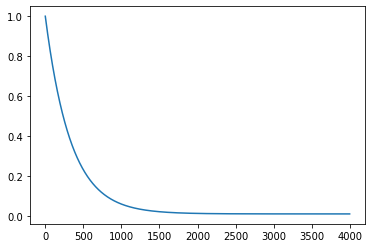

In [3]:
plt.plot(time, epsilon)
plt.show()